# ¡Hola, ART!

## Instalación

In [1]:
!pip install adversarial-robustness-toolbox==1.4.1

     |████████████████████████████████| 768kB 5.1MB/s 
     |████████████████████████████████| 7.1MB 6.2MB/s 
     |████████████████████████████████| 235kB 56.5MB/s 
     |████████████████████████████████| 21.0MB 74.6MB/s 
     |████████████████████████████████| 747kB 52.5MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
from art.utils import load_mnist

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

## Cargar datos

In [5]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [6]:
print("x_train shape:", x_train.shape)
print("y_train shape:", x_train.shape)
print("x_test shape:", x_train.shape)
print("y_test shape:", x_train.shape)

print("min_pixel_value:", min_pixel_value)
print("min_pixel_value:", max_pixel_value)

x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 28, 28, 1)
x_test shape: (60000, 28, 28, 1)
y_test shape: (60000, 28, 28, 1)
min_pixel_value: 0.0
min_pixel_value: 1.0


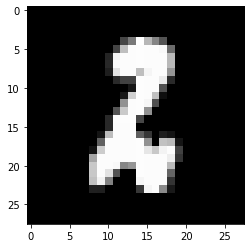

In [7]:
sample = 50897
plt.imshow(x_train[sample].reshape((28, 28)), cmap='gray', interpolation='none')

## Entrenar modelo

In [8]:
from art.estimators.classification import KerasClassifier

In [9]:
model = Sequential()
model.add(Conv2D(filters=4, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=10, kernel_size=(5, 5), strides=1, activation="relu", input_shape=(23, 23, 4)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])
classifier = KerasClassifier(model=model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
937/937 [==============================] - 3s 3ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.1483 - accuracy: 0.9543
Epoch 2/3
937/937 [==============================] - 3s 3ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0733 - accuracy: 0.9782
Epoch 3/3
937/937 [==============================] - 3s 3ms/step - batch: 468.0000 - size: 64.0000 - loss: 0.0670 - accuracy: 0.9800


In [10]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Accuracy on test examples: 97.99%


## Generar ejemplos adversarios

In [11]:
from art.attacks.evasion import FastGradientMethod, SaliencyMapMethod, CarliniL2Method

In [12]:
attack_fgm = FastGradientMethod(estimator = classifier, eps = 0.2)
x_test_fgm = attack_fgm.generate(x=x_test)

In [13]:
predictions_test = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test adversarial examples: {}%".format(accuracy * 100))

Accuracy on test adversarial examples: 34.339999999999996%


In [14]:
attack_jsma = SaliencyMapMethod(classifier = classifier, theta = 0.1)
x_test_jsma = attack_jsma.generate(x=x_test)

JSMA: 100%|██████████| 10000/10000 [35:09<00:00,  4.74it/s]


In [15]:
attack_cw2 = CarliniL2Method(classifier = classifier)
x_test_cw2 = attack_cw2.generate(x=x_test)

C&W L_2: 100%|██████████| 10000/10000 [2:50:29<00:00,  1.02s/it]


In [16]:
attacks = ["fgm", "jsma", "c&w l2"]
x_tests_attacks = [x_test_fgm, x_test_jsma, x_test_cw2]
predictions = []

for i, x in enumerate(x_tests_attacks):
  preds = classifier.predict(x)
  predictions.append(preds)
  accuracy = np.sum(np.argmax(preds, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
  print("Accuracy on adversarial test examples for {} attack: {}%".format(attacks[i], accuracy * 100))

Accuracy on adversarial test examples for fgm attack: 34.339999999999996%
Accuracy on adversarial test examples for jsma attack: 0.33%
Accuracy on adversarial test examples for c&w l2 attack: 84.64%


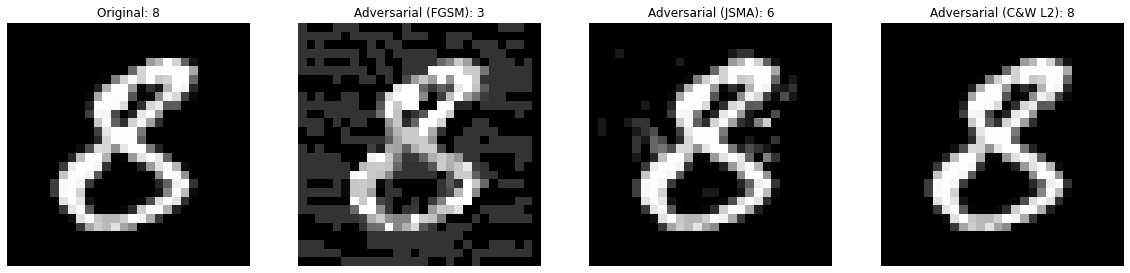

In [17]:
sample = 1234
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(x_test[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Original: {}".format(np.argmax(y_test[sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 2)
ax.imshow(x_test_fgm[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (FGSM): {}".format(np.argmax(predictions[0][sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 3)
ax.imshow(x_test_jsma[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (JSMA): {}".format(np.argmax(predictions[1][sample])))
ax.axis('off')
ax = fig.add_subplot(1, 4, 4)
ax.imshow(x_test_cw2[sample].reshape((28, 28)), cmap='gray', interpolation='none')
ax.set_title("Adversarial (C&W L2): {}".format(np.argmax(predictions[2][sample])))
ax.axis('off')
fig.show()

# Entrenamiento adversario

In [18]:
x_train_fgm = attack_fgm.generate(x=x_train)

In [19]:
x_train = np.append(x_train, x_train_fgm, axis=0)
y_train = np.append(y_train, y_train, axis=0)

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

Epoch 1/3
1875/1875 [==============================] - 6s 3ms/step - batch: 937.0000 - size: 64.0000 - loss: 0.1478 - accuracy: 0.9551
Epoch 2/3
1875/1875 [==============================] - 6s 3ms/step - batch: 937.0000 - size: 64.0000 - loss: 0.0988 - accuracy: 0.9702
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - batch: 937.0000 - size: 64.0000 - loss: 0.0908 - accuracy: 0.9731


In [21]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

predictions_fsm = classifier.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fsm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for JSM attack: {}%".format(accuracy * 100))

Accuracy on test examples: 96.84%
Accuracy on adversarial test examples for JSM attack: 93.22%


## Entrenamiento adversario de forma nativa

In [22]:
from art.defences.trainer import AdversarialTrainer

In [23]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.01), metrics=["accuracy"])

In [24]:
defence = AdversarialTrainer(classifier=classifier, attacks=attack_fgm, ratio=0.5)

In [25]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

In [26]:
defence.fit(x=x_train, y=y_train, nb_epochs=3)

Adversarial training epochs: 100%|██████████| 3/3 [00:26<00:00,  8.72s/it]


In [27]:
predictions_test = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions_test, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on test examples: {}%".format(accuracy * 100))

predictions_fsm = defence.predict(x_test_fgm)
accuracy = np.sum(np.argmax(predictions_fsm, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples for JSM attack: {}%".format(accuracy * 100))

Accuracy on test examples: 97.33000000000001%
Accuracy on adversarial test examples for JSM attack: 93.13%
